In [22]:
# OpenAI Gym
import gym_tetris as gym
import numpy as np

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output

(430, 330, 3)

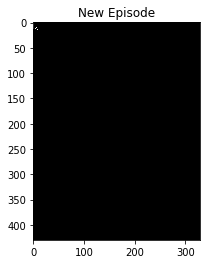

In [23]:
# Load the cart-pole environment
env = gym.make('Tetris-v0')

# Reinitialize the environment for an episode
observation = env.reset()

# Look at the features the agent will observe during training...
display(observation.shape)

# Render the scene for our visualization purposes...
plt.imshow(env.render(mode='rgb_array'))
plt.title("New Episode") 
plt.show()

In [24]:
# Shape of the observation vectors
display(env.observation_space.shape)

# Number of possible actions
display(env.action_space.n)

(430, 330, 3)

12

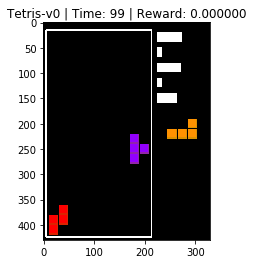

In [7]:

# Initialize the environment and perform 10 random actions
env.reset()
reward = 0.0
for time in range(100):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    observation, reward, done, info = env.step(np.random.choice(env.action_space.n)) # take a random action
    if (done):
        break
clear_output(wait=True)

In [25]:
import keras
import numpy as np

# A simple multilayer architecture....
def make_model(state, action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(8, 8), activation='relu',
                                    input_shape=[state.shape[0],
                                    state.shape[1],
                                    state.shape[2]]))
    model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
    return model

model = make_model(env.reset(), env.action_space.n)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 423, 323, 64)      12352     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 416, 316, 128)     524416    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 208, 158, 128)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 208, 158, 128)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4206592)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                84131860  
_________________________________________________________________
dense_12 (Dense)             (None, 12)                252       
Total para

In [26]:
# Turn our observation vector into a matrix of observations
# with only -one- observation and run predict()
Q = model.predict(np.expand_dims(observation,axis=0))
Q

array([[ 0.31432834, -0.16220891,  0.6073879 ,  0.21523085,  0.54945505,
         0.34151658,  0.91970897,  0.07912086,  0.5713815 , -0.2679149 ,
        -0.8917968 , -0.3464032 ]], dtype=float32)

In [27]:
np.argmax(Q)

6

In [28]:
# Example e-soft policy...
epsilon = 0.5 # Half of the time, a random action is chosen...
action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
action

9

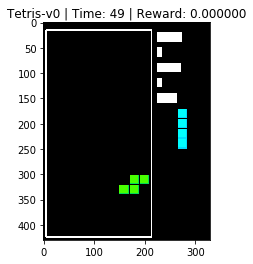

In [12]:

# Initialize the environment and let the agent decide!
observation = env.reset()
epsilon = 1 # No exploration!
reward = 0.0
for time in range(50):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

In [29]:

# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = [state_size.shape[0], state_size.shape[1], state_size.shape[2]]
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size, self.state_size[0], self.state_size[1], 
                                       self.state_size[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size, self.state_size[0], self.state_size[1], 
                                       self.state_size[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model.predict(current_state)
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state),axis=1)
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.fit(current_state,model_targets,
                     epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [30]:

# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
episodes = 50

replay_iterations = 100
replay_sample_size = 256

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
model = make_model(env.reset(), env.action_space.n)
target_model = make_model(env.reset(), env.action_space.n)
memory = ReplayMemory(10000, env.reset(), env.action_space.n)

In [31]:

# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(10):
        Q = model.predict(np.expand_dims(current_state, axis=0)) # Compute Q
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        if done:
            reward = -10.0
        memory.remember(current_state, action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

Episode 7/50 - time: 9, mean-time: 9, epsilon: 0.932065

KeyboardInterrupt: 

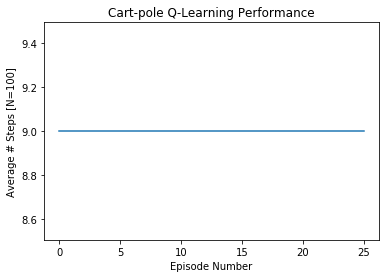

In [16]:

# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

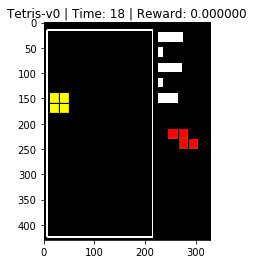

error: display Surface quit

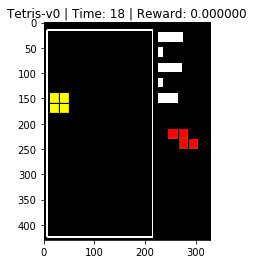

In [32]:

# Test out the agent!
# Initialize the environment and let the agent decide how to act!
observation = env.reset()
for time in range(50):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)